In [13]:
%matplotlib inline
from __future__ import division
import numpy as np
import matplotlib.pyplot as plt
import h5py
from hdf5plotter import h5ls
from brownian import Cantilever, BrownianMotionFitter, get_data, u, Pf, calc_P_x0
import pystan
from stanhelper import *

def Pfi(d, samp, i):
    fc = d['mu_fc'] + samp['dfc'][i]
    Q = samp['Q'][i]
    kc = samp['kc'][i]
    return Pf(d['f'], 
              calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude,
              fc, Q, samp['Pdet'][i]*d['scale']
             )

## Naive model

- Collect power spectral density of position fluctuation data, mean $y$, and standard deviation $y_\sigma$, for $N$ samples.


$$
\begin{align}
\mu_i &\sim \frac{P_0 f_\text{c}^4}{(f^2-f_\text{c}^2)^2 + f^2 f_\text{c}^2/Q^2} +  P_\text{det}& \\
\sigma_i & \sim \frac{y_\sigma}{\sqrt{N}} \\
y &\sim \mathcal{N}(\mu, \sigma)&
\end{align}
$$

An example dataset is plotted below:

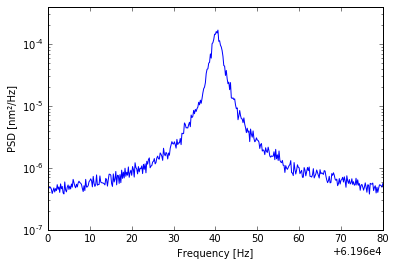

In [2]:
fh = h5py.File('brownianallpts155452.h5', 'r')
plt.semilogy(fh['f_subset'][:], np.mean(fh['PSD_subset'][:], 0))
plt.xlim(61960, 62040)
plt.ylim(1e-7, 4e-4)
plt.xlabel("Frequency [Hz]")
plt.ylabel(u"PSD [nm²/Hz]")

## Standard curve fitting

The below analysis estimates the maximum likelihood parameters using `scipy.optimize.curve_fit`.

In [3]:
bmf = BrownianMotionFitter(*get_data('brownianallpts155452.h5'), T=298,
                          est_cant=Cantilever(f_c=62*u.kHz,
                                     k_c=3.5*u.N/u.m,
                                     Q=28000*u.dimensionless)
                          )
bmf.calc_fit(61960, 62040)


Residuals
-------------------------------------
        Mean: -3.21e-02
   Std. dev.: 1.45e-01


(<matplotlib.figure.Figure at 0x1124bc750>,
 <matplotlib.axes._subplots.AxesSubplot at 0x1061be110>)

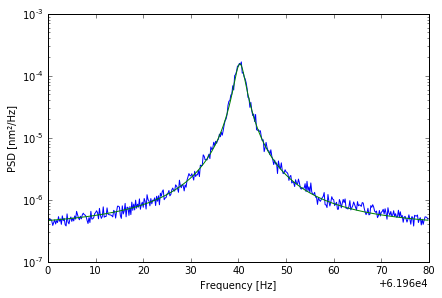

In [4]:
bmf.plot_fit()

(<matplotlib.figure.Figure at 0x1124bcf10>,
 <matplotlib.axes._subplots.AxesSubplot at 0x112d8fb50>)

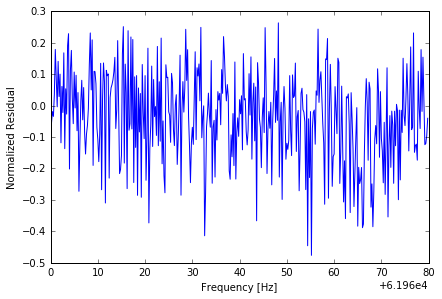

In [5]:
bmf.plot_reduced_residuals()

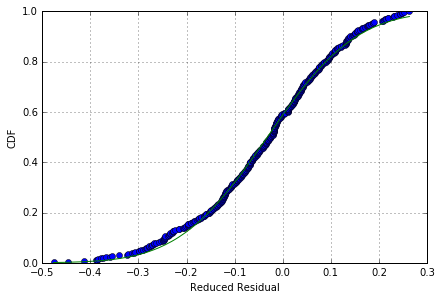

In [6]:
fig, ax = bmf.plot_cdf()
ax.grid(color='k', zorder=0)

The model poorly describes the residuals / noise, even with $N=64$ averages.

In [7]:
print(bmf.report())


    Input
    -----------------------------------------------
    Temperature           T: 298 kelvin

    Estimates
    -----------------------------------------------
    Spring constant     k_c: 3.5 newton/meter
    Resonance frequency f_c: 62 kilohertz
    Quality factor        Q: 28000 dimensionless
    
    Fitting
    -----------------------------------------------
    Fit frequency min f_min: 61960 hertz
    Fit frequency max f_max: 62040 hertz

    Results
    -----------------------------------------------
    Resonance frequency f_c: 62000.31(3) hertz
    Spring constant     k_c: 7.3(2) newton/meter
    Quality Factor        Q: 2.68(7)×10⁴ dimensionless
    Detector Noise         : 3.35(7)×10⁻⁷ nanometer²/hertz
            


The above report shows the 2 standard deviation confidence interval.

# Baynesian fitting: same model

Let's use ``stan`` to examine a similar naive model.

$$
\begin{align}
\mu_i &\sim P(x_i, f_\text{c}, k_\text{c}, Q) + P_\text{det}& \\
y &\sim \mathcal{N}(\mu, k \mu)&
\end{align}
$$

In [8]:
d = fh2data(fh, 61960, 62040, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)
m = pystan.StanModel(model_code=naive_stan)

In [9]:
m2 = pystan.StanModel(model_code=naive_stan2)

In [10]:
out2 = m2.sampling(data=d, init=initial(d, Pdet=0.02), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

In [11]:
out2

Inference for Stan model: anon_model_b01d96fd8d8d73705526c9987a94f2aa.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc    0.31  3.3e-4   0.03   0.25   0.29   0.31   0.33   0.37 8000.0    1.0
kc     7.23  1.8e-3   0.16   6.92   7.12   7.23   7.34   7.56 8000.0    1.0
Q     2.7e4    7.83 700.05  2.6e4  2.7e4  2.7e4  2.7e4  2.8e4 8000.0    1.0
Pdet   0.04  1.0e-5 9.2e-4   0.04   0.04   0.04   0.05   0.05 8000.0    nan
k      0.14  5.5e-5 5.0e-3   0.13   0.14   0.14   0.14   0.15 8000.0    1.0
lp__ 1226.0    0.02   1.57 1222.1 1225.2 1226.4 1227.2 1228.2 8000.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Feb  3 19:04:47 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

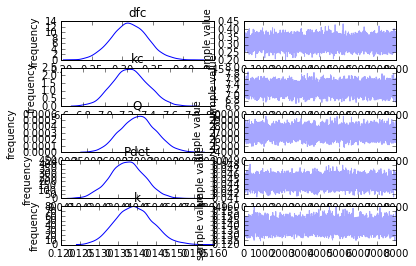

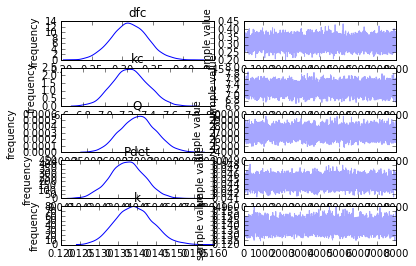

In [12]:
out2.traceplot()

In [45]:
fc = d['mu_fc'] + np.median(samp2['dfc'])
Q = np.median(samp2['Q'])
kc = np.median(samp2['kc'])
psd50 = Pf(d['f'], calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude, fc, Q, np.mean(samp2['Pdet'])*d['scale'])

In [46]:
fc = d['mu_fc'] + np.median(samp['dfc'])
Q = np.median(samp['Q'])
kc = np.median(samp['kc'])
psd50_2 = Pf(d['f'], calc_P_x0(fc*u.Hz, Q, kc*u('N/m'), d['T']*u.K).to('nm^2/Hz').magnitude, fc, Q, np.mean(samp['Pdet'])*d['scale'])

(3e-07, 0.0005)

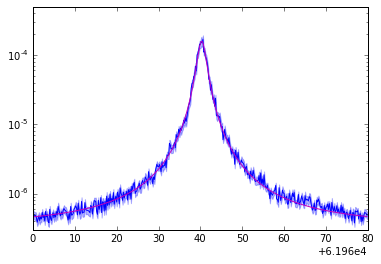

In [48]:
plt.semilogy(d['f'], d['y']*d['scale'])
plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
                 color='b', alpha=0.3)
# plt.semilogy(d['f'], psd50, 'g-')
plt.semilogy(d['f'], psd50, 'm-')
# plt.semilogy(d['f'], Pfi(d, samp, 2000))
plt.ylim(3e-7, 5e-4)

(1e-06, 0.0003)

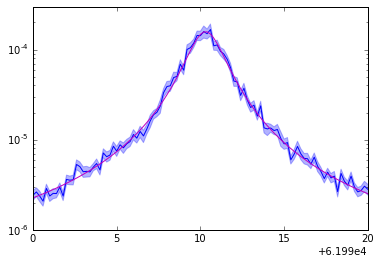

In [49]:
plt.semilogy(d['f'], d['y']*d['scale'])
plt.fill_between(d['f'], d['y']*d['scale']-d['y_err']*d['scale'], d['y']*d['scale']+d['y_err']*d['scale'],
                 color='b', alpha=0.3)
# plt.semilogy(d['f'], psd50, 'g-')
plt.semilogy(d['f'], psd50, 'm-')
# plt.semilogy(d['f'], Pfi(d, samp, 2000))
plt.xlim(61990, 62010)
plt.ylim(1e-6, 3e-4)

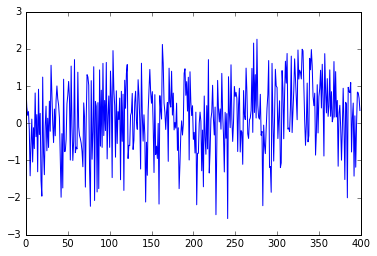

In [50]:
plt.plot( (d['y'] - (Pfi(d, samp2, 1000) / d['scale'])) / (samp2['k'][1000] * d['y']))

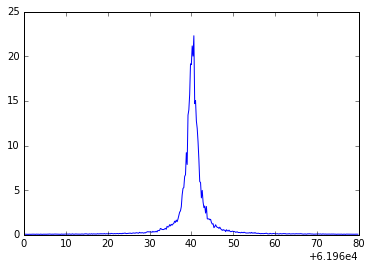

In [51]:
plt.plot(d['f'], d['y'])

In [52]:
Pfi(d, samp, 1000)

array([  4.18293775e-07,   4.20298051e-07,   4.22332343e-07,
         4.24397252e-07,   4.26493396e-07,   4.28621406e-07,
         4.30781932e-07,   4.32975637e-07,   4.35203204e-07,
         4.37465332e-07,   4.39762740e-07,   4.42096163e-07,
         4.44466357e-07,   4.46874098e-07,   4.49320182e-07,
         4.51805427e-07,   4.54330670e-07,   4.56896775e-07,
         4.59504626e-07,   4.62155133e-07,   4.64849228e-07,
         4.67587873e-07,   4.70372052e-07,   4.73202779e-07,
         4.76081097e-07,   4.79008075e-07,   4.81984816e-07,
         4.85012452e-07,   4.88092148e-07,   4.91225103e-07,
         4.94412548e-07,   4.97655754e-07,   5.00956026e-07,
         5.04314708e-07,   5.07733185e-07,   5.11212881e-07,
         5.14755265e-07,   5.18361848e-07,   5.22034189e-07,
         5.25773892e-07,   5.29582612e-07,   5.33462054e-07,
         5.37413977e-07,   5.41440194e-07,   5.45542575e-07,
         5.49723049e-07,   5.53983607e-07,   5.58326303e-07,
         5.62753257e-07,

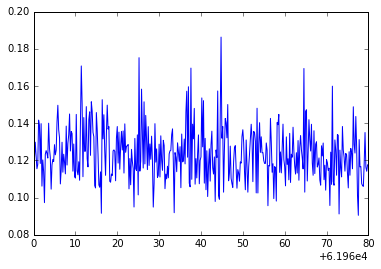

In [53]:
plt.plot(d['f'], d['y_err']/d['y'])

In [54]:
m.sampling(data=d, init=initial(d), iter=2000)

/Users/ryandwyer/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanM

Inference for Stan model: anon_model_e2a547fb75859903e98c980bde6c43d4.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

       mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc  3.7e-3    0.02   0.99  -1.92  -0.66   0.02   0.67   1.91 4000.0    1.0
kc     4.59    0.04   2.71    0.4   2.52    4.3   6.36  10.51 4000.0    1.0
Q     2.8e4   39.86 2521.0  2.3e4  2.6e4  2.8e4  3.0e4  3.3e4 4000.0    1.0
Pdet   0.08  9.9e-6 6.3e-4   0.08   0.08   0.08   0.09   0.09 4000.0    nan
lp__  -4235    0.02   1.45  -4238  -4235  -4234  -4234  -4233 4000.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Feb  3 08:16:30 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

# Lognormal stan

Let's assume our lognormal mean $\mu$ and standard deviation $\sigma$ are linearly related to our predictor $P(f, f_\text{c}, k_\text{c}, Q)$. Then we have,

$$
\begin{align}
y & \sim \log \mathcal{N}(\mu, \sigma)& \\
\mu& \sim  \log(P(f, f_\text{c}, k_\text{c}, Q)) - \frac{\sigma^2}{2}& \\
\sigma& \sim  \alpha_\sigma + \beta_\sigma P(f, f_\text{c}, k_\text{c}, Q))& 
\end{align}
$$

Note: sigma is on a log scale; I can probably get away with just $\sigma ~ \alpha_\sigma$, with perhaps an exponentially weighted prior, with size 4.

In [14]:
lognormal_stan = """
data {
  int<lower=0> N;
  int<lower=0> M;
  vector[N] f;
  vector[N] y[M];
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
  # No priors yet
  real<lower=0> alpha_sigma;
}

model {
    vector[N] P;
    vector[N] mu;
    vector[N] sigma;
    P <- ((2 * 1.381e-5 * T) / (pi() * Q * kc)) / scale * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet;
    
    mu <- log(P) - alpha_sigma .* alpha_sigma / 2;


    Pdet ~ normal(0, sigma_Pdet);
    alpha_sigma ~ normal(2, 4);

    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);
    
    for (i in 1:M) {
        y[i] ~ lognormal(mu, alpha_sigma);
    }
}
"""

In [18]:
lognormal_simple = """
data {
  int<lower=0> N;
  vector[N] f;
  vector[N] y;
  real mu_fc;
  real mu_kc;
  real mu_Q;
  real sigma_fc;
  real sigma_kc;
  real sigma_Q;
  real sigma_Pdet;
  real scale;
  real<lower=0> T;
}
parameters {
  real dfc;
  real<lower=0> kc;
  real<lower=0> Q;
  real<lower=0> Pdet;
  # No priors yet
  real<lower=0> alpha_sigma;
}

model {
    vector[N] P;
    vector[N] mu;
    P <- ((2 * 1.381e-5 * T) / (pi() * Q * kc)) / scale * (dfc + mu_fc)^3 ./
            ((f .* f - (dfc + mu_fc)^2) .* (f .* f - (dfc + mu_fc)^2) + f .* f * (dfc + mu_fc)^2 / Q^2)
            + Pdet;
    
    mu <- log(P) - alpha_sigma .* alpha_sigma / 2;


    Pdet ~ normal(0, sigma_Pdet);
    alpha_sigma ~ normal(1, 2);

    # Priors on fit parameters
    dfc ~ normal(0, sigma_fc);
    kc ~ normal(mu_kc, sigma_kc);
    Q ~ normal(mu_Q, sigma_Q);

    y ~ lognormal(mu, alpha_sigma);

}
"""

In [19]:
mlog = pystan.StanModel(model_code=lognormal_stan)

In [20]:
mlog_simp = pystan.StanModel(model_code=lognormal_simple)

In [21]:
dlog = fh2data_all(fh, 61960, 62040, 62000, 3.5, 28000, sigma_fc=1, sigma_Q=2500, sigma_kc=3.5, sigma_Pdet=2e-7)

In [22]:
def initial_all(d, k0=0.6, Pdet=None, alpha_sigma=2):
    if Pdet is None:
        Pdet = d['sigma_Pdet']*0.1
    return lambda: {'dfc': 0, 'kc': d['mu_fc'],
                    'Q': d['mu_Q'], 'Pdet': Pdet, 'k': k0,
                      'alpha_sigma': alpha_sigma}

In [23]:
mlog_simp.sampling(data=d, init=initial_all(dlog, alpha_sigma=0.5))

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

Inference for Stan model: anon_model_2262a03eb02d0e3dabfe97a403665842.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc           0.31  4.5e-4   0.03   0.25   0.29   0.31   0.33   0.37 4000.0    1.0
kc            7.01  2.5e-3   0.16   6.71   6.91   7.01   7.12   7.32 4000.0    1.0
Q            2.7e4    10.9 689.47  2.6e4  2.6e4  2.7e4  2.7e4  2.8e4 4000.0    1.0
Pdet          0.05  1.5e-5 9.5e-4   0.04   0.05   0.05   0.05   0.05 4000.0    nan
alpha_sigma   0.14  8.0e-5 5.1e-3   0.13   0.14   0.14   0.14   0.15 4000.0    1.0
lp__        591.92    0.03   1.58 588.04 591.08 592.24  593.1 594.01 4000.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Feb  3 19:13:29 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [24]:
mlog.sampling(data=dlog, init=initial_all(dlog), iter=4000)

/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an experimental feature!
The relevant StanModel instance must be pickled along with this fit object.
When unpickling the StanModel must be unpickled first.
  return send(obj)
/Users/ryandwyer/anaconda/envs/py27/lib/python2.7/multiprocessing/queues.py:392: UserWarning: Pickling fit objects is an 

Inference for Stan model: anon_model_96824a6476c6a9b34475248315ebae77.
4 chains, each with iter=4000; warmup=2000; thin=1; 
post-warmup draws per chain=2000, total post-warmup draws=8000.

              mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
dfc           0.33  3.7e-4   0.03   0.26   0.31   0.33   0.35   0.39 8000.0    1.0
kc            5.43  1.6e-3   0.15   5.15   5.33   5.43   5.53   5.72 8000.0    1.0
Q            2.7e4    9.03 808.11  2.6e4  2.7e4  2.7e4  2.8e4  2.9e4 8000.0    1.0
Pdet          0.06  1.7e-5 1.5e-3   0.06   0.06   0.06   0.06   0.06 8000.0    1.0
alpha_sigma   1.28  6.3e-5 5.6e-3   1.27   1.27   1.28   1.28   1.29 8000.0    1.0
lp__        -1.9e4    0.02   1.57 -1.9e4 -1.9e4 -1.9e4 -1.9e4 -1.9e4 8000.0    1.0

Samples were drawn using NUTS(diag_e) at Wed Feb  3 19:21:32 2016.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).

In [25]:
out_bay = _

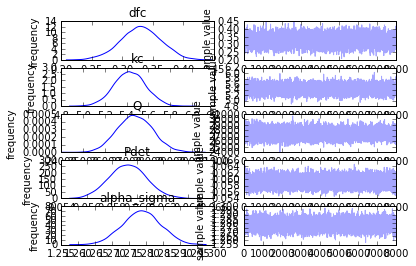

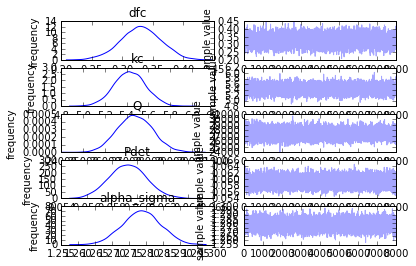

In [26]:
out_bay.traceplot()

In [29]:
samp_bay = out_bay.extract(permuted=True)

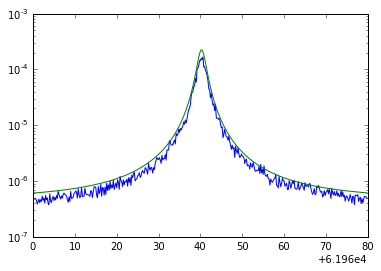

In [31]:
plt.semilogy(dlog['f'], np.mean(dlog['y'], 0)*dlog['scale'])
plt.plot(dlog['f'], Pf(dlog['f'], ))

In [68]:
np.sqrt(np.exp(0.13**2)-1)

0.13055118872903981

In [ ]:
plt.semilogy(dlog['f'], np.mean(dlog['y'], 0)*dlog['scale'])
plt.plot(dlog['f'], Pfi(dlog, samp_bay, 4053))